In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_VI"
plane = "V"

In [45]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -40 and x - mu_x[0] < 40:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    emittance_wire = ((sigma_wire)**2 / 4.22) * beta_rel * gamma_rel
    norm_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", emittance_wire, np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity)
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
        sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [50]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results_2_03")

# result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
result_folders.remove('data.txt')
result_folders.remove('emittance.png')

print(result_folders)

['PROFILE_320_V_R3_2018_10_24_17_47', 'PROFILE_300_V_R3_2018_10_24_17_24', 'PROFILE_340_V_R3_2018_10_24_18_06', 'PROFILE_500_V_R3_2018_10_24_18_40', 'PROFILE_310_V_R3_2018_10_24_17_31', 'PROFILE_285_V_R3_2018_10_24_17_12', 'PROFILE_400_V_R3_2018_10_24_18_29', 'PROFILE_350_V_R3_2018_10_24_18_19', 'PROFILE_330_V_R3_2018_10_24_18_01', 'PROFILE_290_V_R3_2018_10_24_17_18']



PROFILE_320_V_R3_2018_10_24_17_47


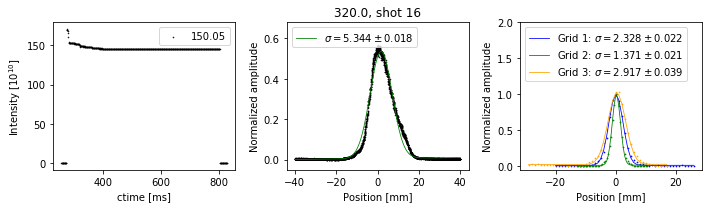

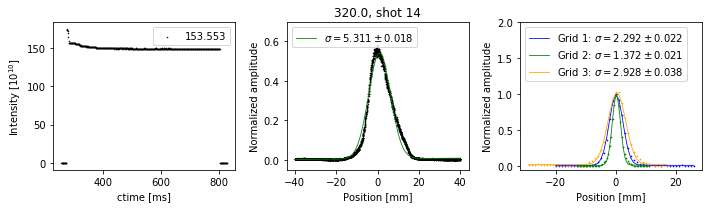

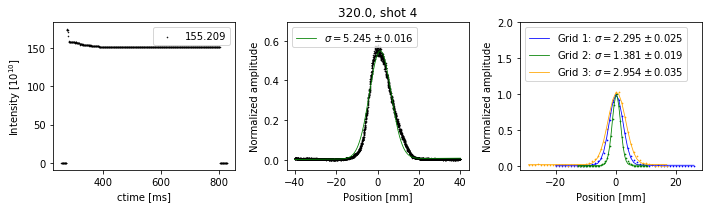

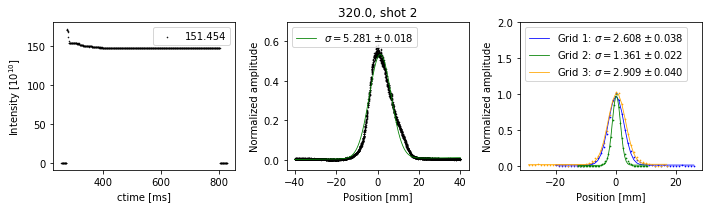

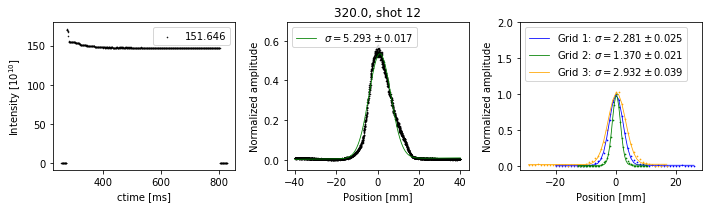

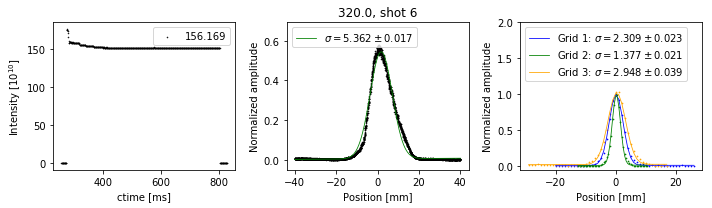

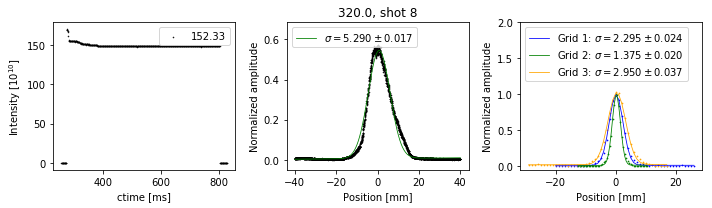

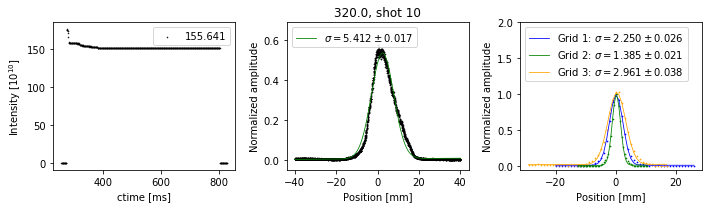

Recorded intensities: [ 150.05   153.553  155.209  151.454  151.646  156.169  152.33   155.641]
Intensities after outlier exclusion: [0, 153.553, 155.209, 151.45400000000001, 151.64600000000002, 0, 152.33000000000001, 0]
Beta wire: 4.2084148858
Beta rel: 0.37581 Gamma rel: 1.0791
2.74421883717 0
An intensity value was excluded.
2.71025533953 153.553
2.64349709269 155.209
2.68023015727 151.454
2.69245431491 151.646
2.76295317394 0
An intensity value was excluded.
2.68920959444 152.33
2.81458447042 0
An intensity value was excluded.

Normal emittance: [ 2.74421884  2.71025534  2.64349709  2.68023016  2.69245431  2.76295317
  2.68920959  2.81458447] 2.71717537255 0.0506828725684
Normalized emittance: [1.6860265253886044, 1.6269508616271036, 1.690455884576523, 1.6960157602388581, 1.6863655044940014] 1.67716290727 0.0253638891348
Intensity: [ 150.05   153.553  155.209  151.454  151.646  156.169  152.33   155.641]

Outliers excluded: [1.6860265253886044, 1.6269508616271036, 1.690455884576523

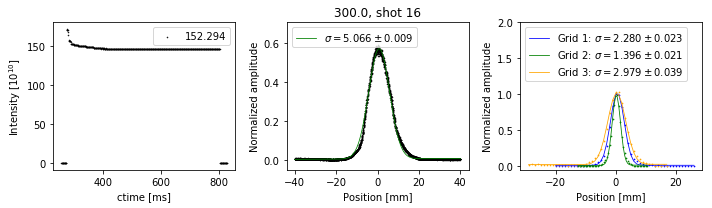

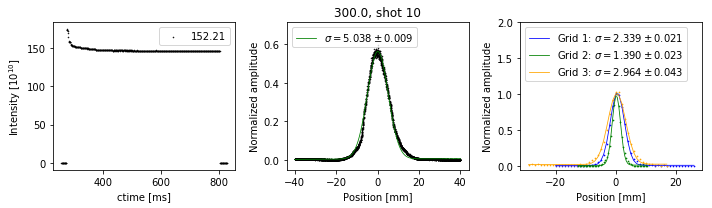

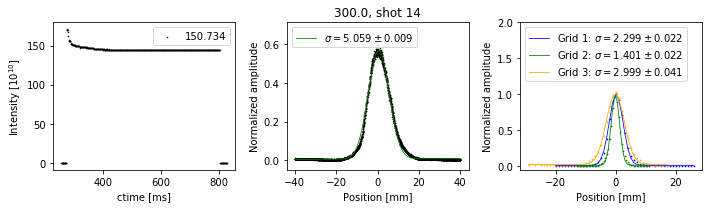

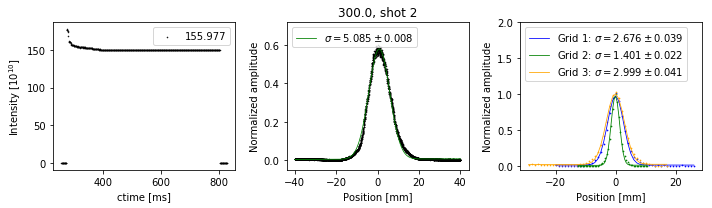

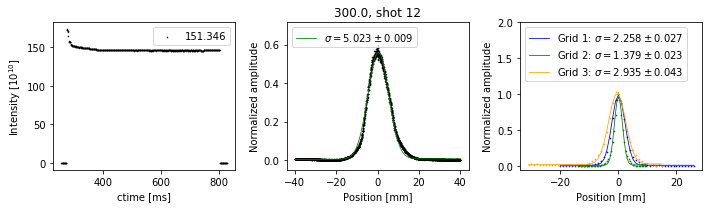

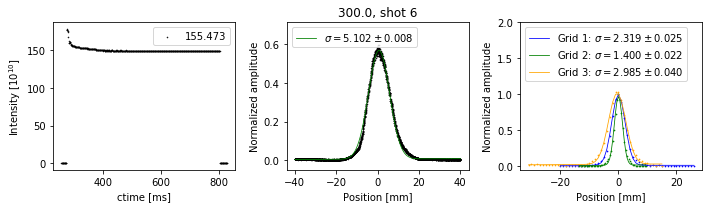

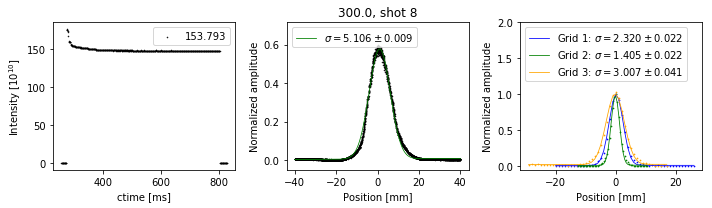

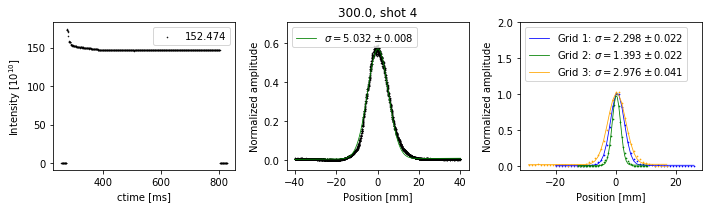

Recorded intensities: [ 152.294  152.21   150.734  155.977  151.346  155.473  153.793  152.474]
Intensities after outlier exclusion: [152.29400000000001, 152.21000000000001, 0, 0, 151.346, 0, 153.79300000000001, 152.47399999999999]
Beta wire: 4.2056803432
Beta rel: 0.34446 Gamma rel: 1.06519
2.23187228174 152.294
2.20703491183 152.21
2.22519794577 0
An intensity value was excluded.
2.24835104275 0
An intensity value was excluded.
2.1938698887 151.346
2.2633349901 0
An intensity value was excluded.
2.26677525717 153.793
2.20166417224 152.474

Normal emittance: [ 2.23187228  2.20703491  2.22519795  2.24835104  2.19386989  2.26333499
  2.26677526  2.20166417] 2.22976256129 0.0261300004151
Normalized emittance: [1.396105401185965, 1.381330748552446, 1.3809297387838835, 1.4041178391304878, 1.375583455175214] 1.38761343657 0.0107086245998
Intensity: [ 152.294  152.21   150.734  155.977  151.346  155.473  153.793  152.474]

Outliers excluded: [1.396105401185965, 1.381330748552446, 1.380929738

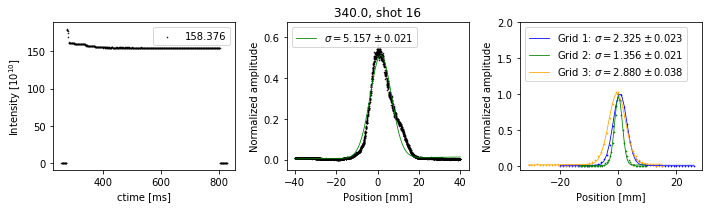

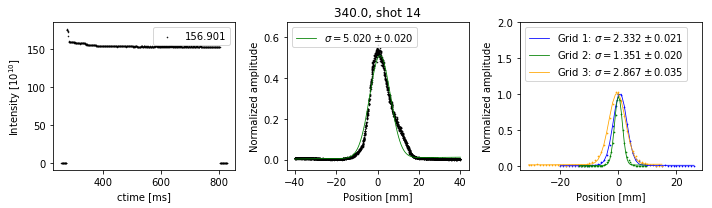

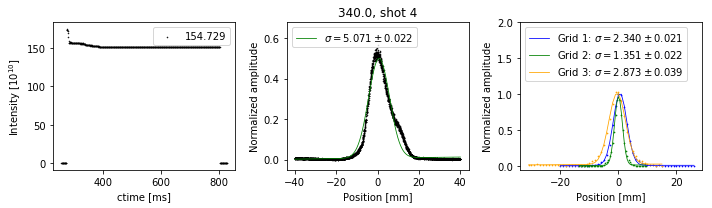

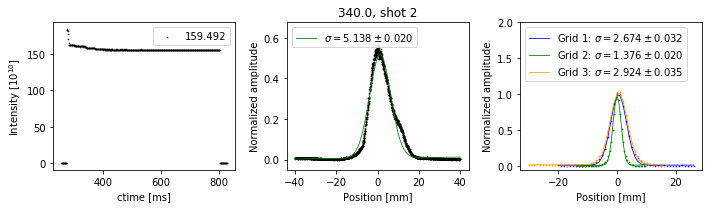

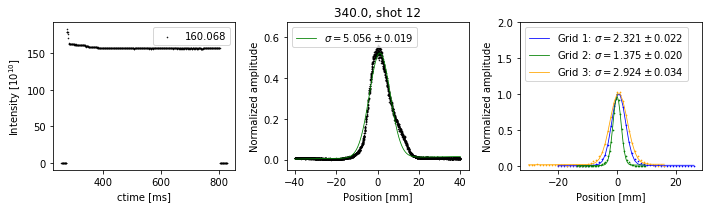

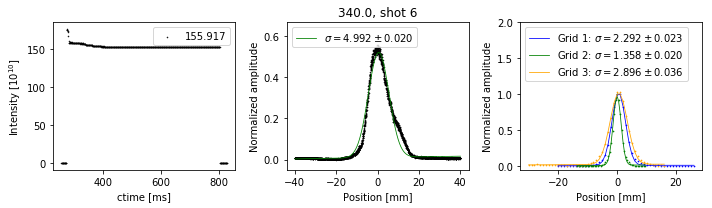

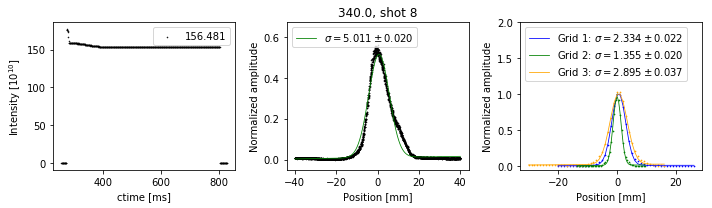

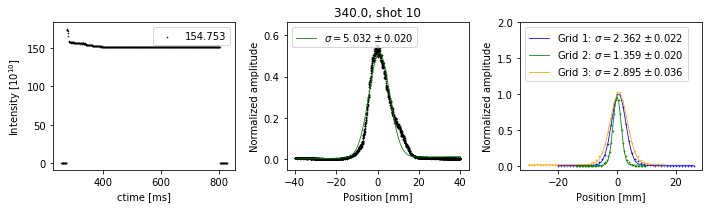

Recorded intensities: [ 158.376  156.901  154.729  159.492  160.068  155.917  156.481  154.753]
Intensities after outlier exclusion: [158.376, 156.90100000000001, 0, 0, 0, 155.917, 156.48099999999999, 0]
Beta wire: 4.211417984775
Beta rel: 0.40967 Gamma rel: 1.09621
2.82981151097 158.376
2.6818554443 156.901
2.7370493834 0
An intensity value was excluded.
2.80944131793 0
An intensity value was excluded.
2.72090169743 0
An intensity value was excluded.
2.65148522926 155.917
2.67164676051 156.481
2.69509914161 0
An intensity value was excluded.

Normal emittance: [ 2.82981151  2.68185544  2.73704938  2.80944132  2.7209017   2.65148523
  2.67164676  2.69509914] 2.72466131068 0.0605014036477
Normalized emittance: [1.4018869179571409, 1.3410794195092623, 1.3342603687159387, 1.3395602983768113] 1.35419675114 0.0276500519611
Intensity: [ 158.376  156.901  154.729  159.492  160.068  155.917  156.481  154.753]

Outliers excluded: [1.4018869179571409, 1.3410794195092623, 1.3342603687159387, 1.33

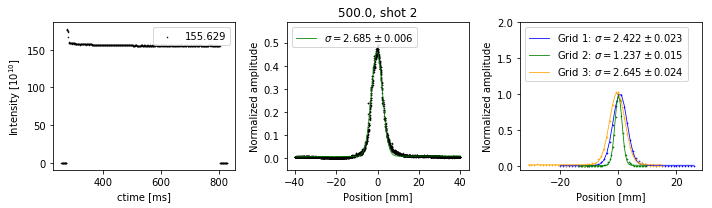

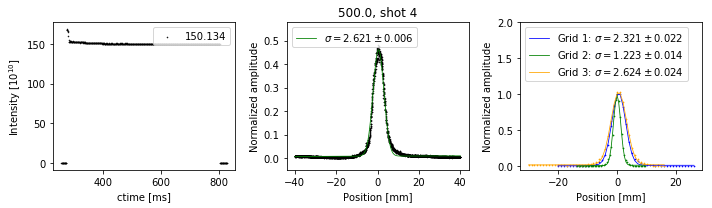

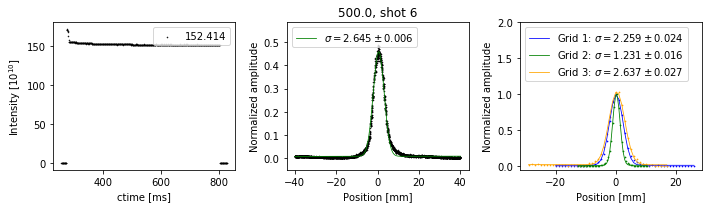

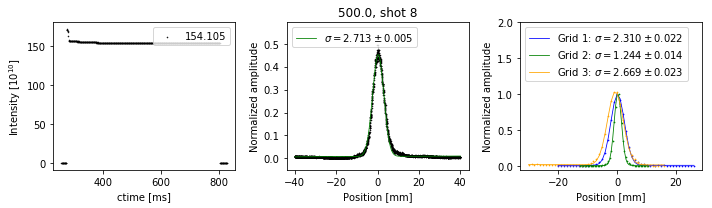

Recorded intensities: [ 155.629  150.134  152.414  154.105]
Intensities after outlier exclusion: [0, 0, 152.41400000000002, 154.10499999999999]
Beta wire: 4.216360053175
Beta rel: 0.71309 Gamma rel: 1.42638
1.73735037855 0
An intensity value was excluded.
1.65530997537 0
An intensity value was excluded.
1.68604257407 152.414
1.77392549467 154.105

Normal emittance: [ 1.73735038  1.65530998  1.68604257  1.77392549] 1.71315710567 0.0457154237165
Normalized emittance: [0.84769785544922682, 0.88209640943128942] 0.86489713244 0.017199276991
Intensity: [ 155.629  150.134  152.414  154.105]

Outliers excluded: [0.84769785544922682, 0.88209640943128942] 0.86489713244 0.017199276991

PROFILE_310_V_R3_2018_10_24_17_31


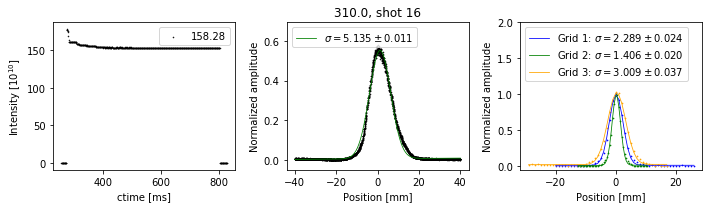

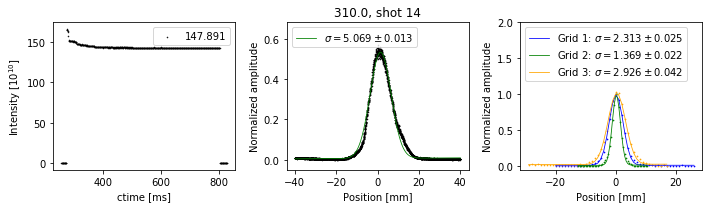

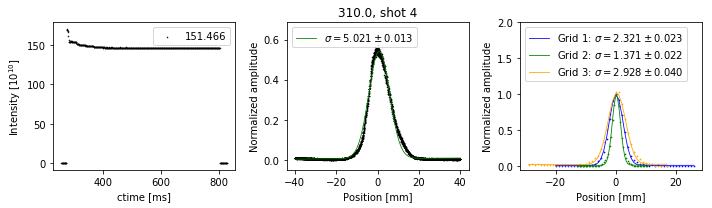

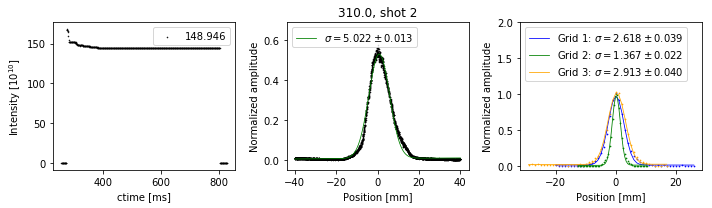

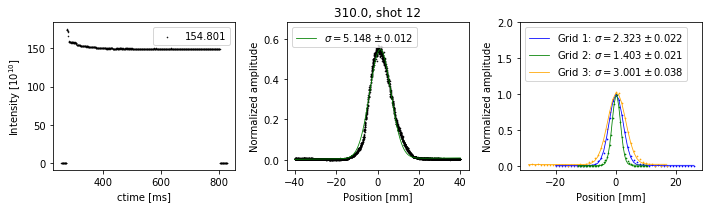

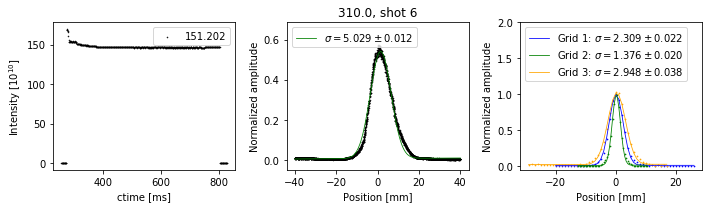

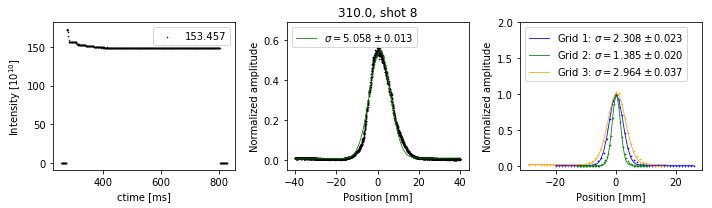

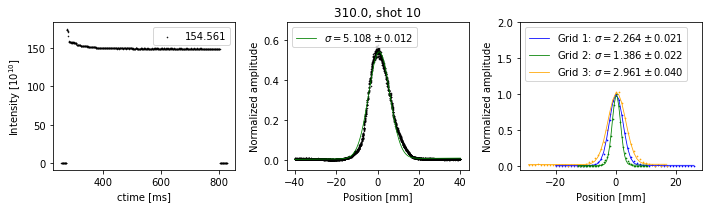

Recorded intensities: [ 158.28   147.891  151.466  148.946  154.801  151.202  153.457  154.561]
Intensities after outlier exclusion: [0, 0, 151.46600000000001, 0, 154.80100000000002, 151.202, 153.45699999999999, 154.56100000000001]
Beta wire: 4.2068440962
Beta rel: 0.35976 Gamma rel: 1.07176
2.40927605604 0
An intensity value was excluded.
2.34764238743 0
An intensity value was excluded.
2.30334195132 151.466
2.30392977928 0
An intensity value was excluded.
2.42134082588 154.801
2.31077753231 151.202
2.33781710323 153.457
2.38366568896 154.561

Normal emittance: [ 2.40927606  2.34764239  2.30334195  2.30392978  2.42134083  2.31077753
  2.3378171   2.38366569] 2.35222391556 0.0442843066071
Normalized emittance: [1.4550941467779412, 1.4966835847143902, 1.4623402475473555, 1.457711770155323, 1.4756836275377567] 1.46950267535 0.0153293021157
Intensity: [ 158.28   147.891  151.466  148.946  154.801  151.202  153.457  154.561]

Outliers excluded: [1.4550941467779412, 1.4966835847143902, 1.46

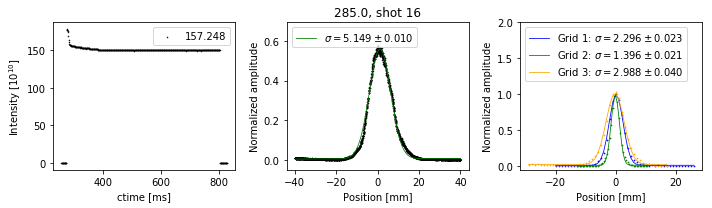

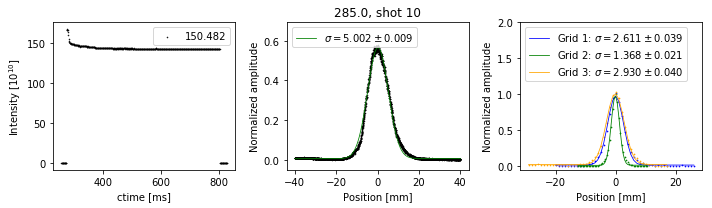

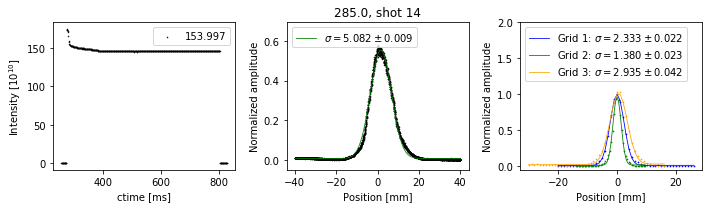

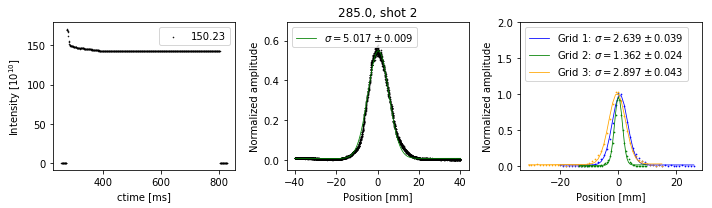

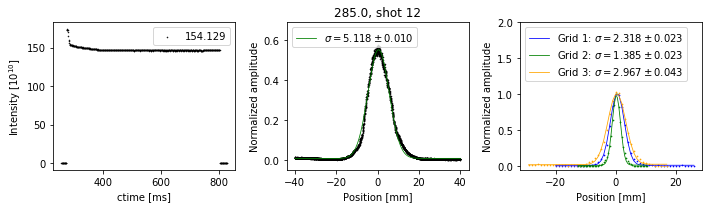

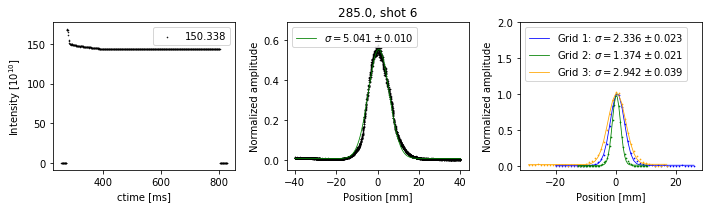

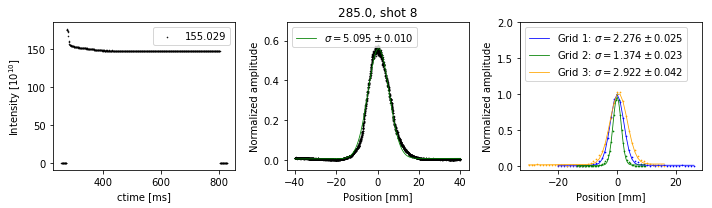

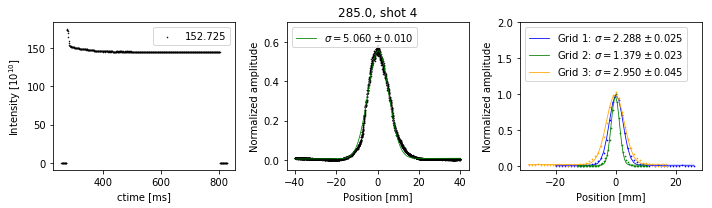

Recorded intensities: [ 157.248  150.482  153.997  150.23   154.129  150.338  155.029  152.725]
Intensities after outlier exclusion: [0, 0, 153.99700000000001, 0, 154.12899999999999, 0, 155.029, 152.72499999999999]
Beta wire: 4.21631758705
Beta rel: 0.32403 Gamma rel: 1.05703
2.15142790246 0
An intensity value was excluded.
2.03103112401 0
An intensity value was excluded.
2.09633488981 153.997
2.04285355163 0
An intensity value was excluded.
2.12572311831 154.129
2.0625368442 0
An intensity value was excluded.
2.106955879 155.029
2.07767259664 152.725

Normal emittance: [ 2.1514279   2.03103112  2.09633489  2.04285355  2.12572312  2.06253684
  2.10695588  2.0776726 ] 2.08681698826 0.0385720336901
Normalized emittance: [1.0479836717069702, 1.0617651075583405, 1.0462816527563286, 1.0473047952378292] 1.05083380681 0.00634020179807
Intensity: [ 157.248  150.482  153.997  150.23   154.129  150.338  155.029  152.725]

Outliers excluded: [1.0479836717069702, 1.0617651075583405, 1.046281652756

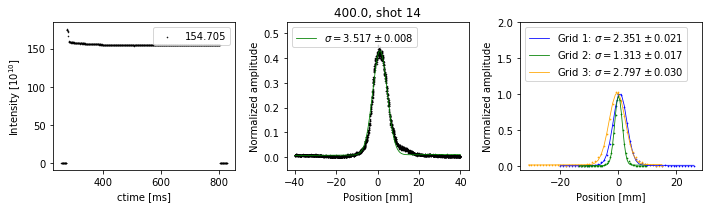

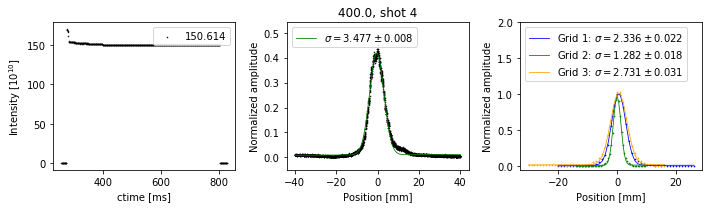

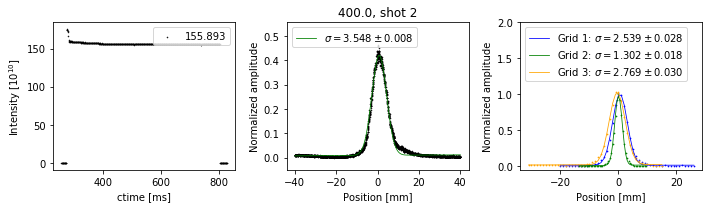

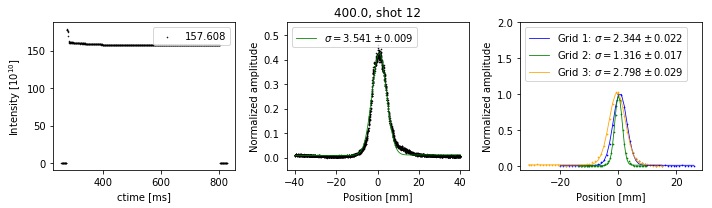

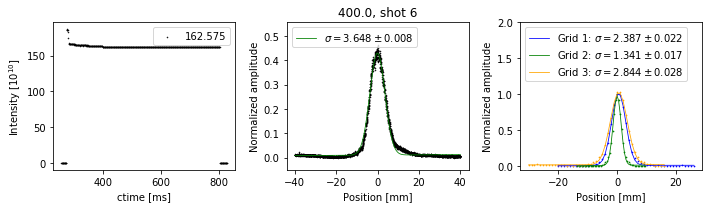

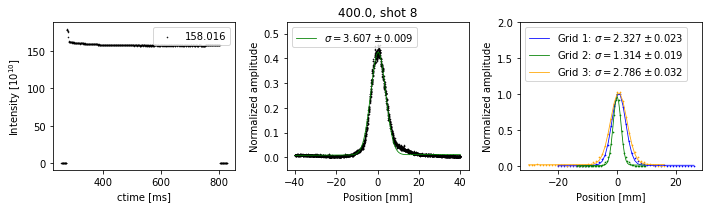

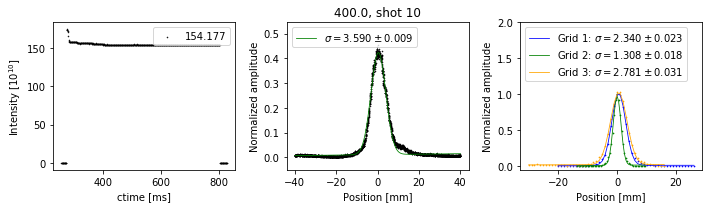

Recorded intensities: [ 154.705  150.614  155.893  157.608  162.575  158.016  154.177]
Intensities after outlier exclusion: [154.70500000000001, 0, 155.893, 157.608, 0, 158.01599999999999, 154.17699999999999]
Beta wire: 4.214021750425
Beta rel: 0.52149 Gamma rel: 1.17198
1.79177665558 154.705
1.75050106162 0
An intensity value was excluded.
1.82362761744 155.893
1.81608722509 157.608
1.92773891686 0
An intensity value was excluded.
1.88406971765 158.016
1.8660470029 154.177

Normal emittance: [ 1.79177666  1.75050106  1.82362762  1.81608723  1.92773892  1.88406972
  1.866047  ] 1.83712117102 0.0553380738787
Normalized emittance: [1.291213886555912, 1.3041519953002876, 1.284627189315225, 1.3292741816255003, 1.3493407994084687] 1.31172161044 0.0242291956211
Intensity: [ 154.705  150.614  155.893  157.608  162.575  158.016  154.177]

Outliers excluded: [1.291213886555912, 1.3041519953002876, 1.284627189315225, 1.3292741816255003, 1.3493407994084687] 1.31172161044 0.0242291956211

PROFILE_

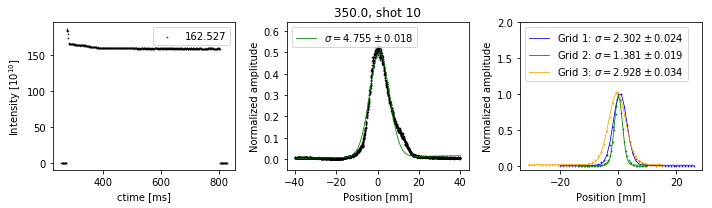

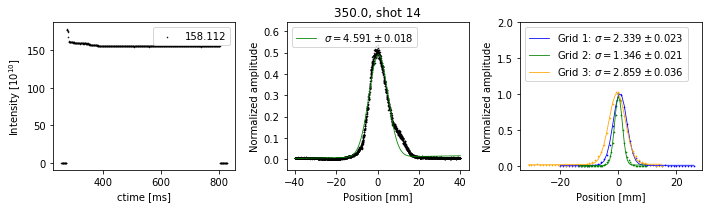

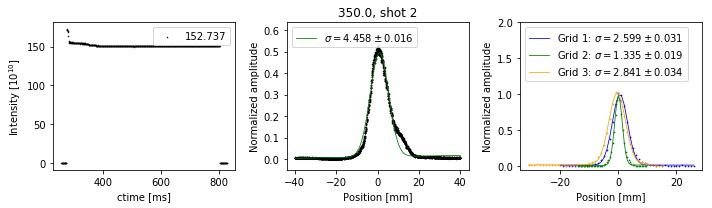

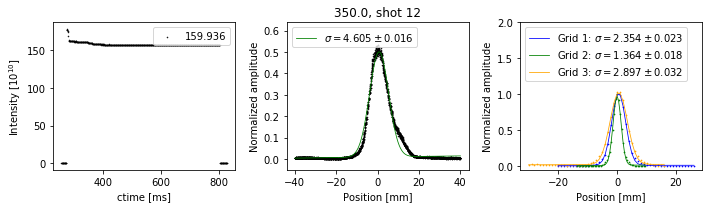

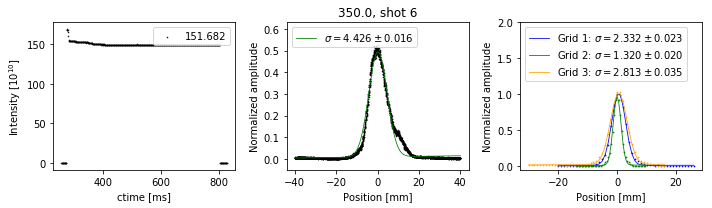

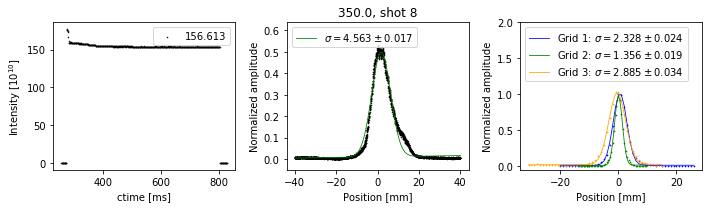

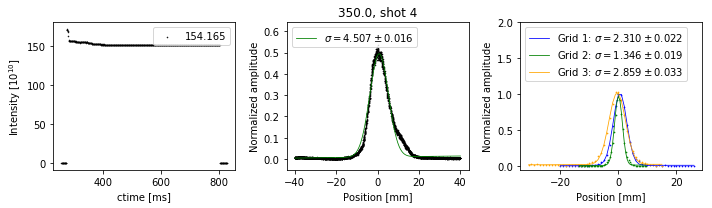

Recorded intensities: [ 162.527  158.112  152.737  159.936  151.682  156.613  154.165]
Intensities after outlier exclusion: [0, 158.11199999999999, 0, 159.93600000000001, 0, 156.613, 154.16499999999999]
Beta wire: 4.211490704125
Beta rel: 0.4273 Gamma rel: 1.10606
2.53190168932 0
An intensity value was excluded.
2.36080865342 158.112
2.22603798823 0
An intensity value was excluded.
2.37503545884 159.936
2.19438538098 0
An intensity value was excluded.
2.3314781381 156.613
2.274493534 154.165

Normal emittance: [ 2.53190169  2.36080865  2.22603799  2.37503546  2.19438538  2.33147814
  2.27449353] 2.32773440613 0.104189597
Normalized emittance: [1.3413076646325124, 1.3340015001024821, 1.3373219990547929, 1.3253524016604703] 1.33449589136 0.00587866835303
Intensity: [ 162.527  158.112  152.737  159.936  151.682  156.613  154.165]

Outliers excluded: [1.3413076646325124, 1.3340015001024821, 1.3373219990547929, 1.3253524016604703] 1.33449589136 0.00587866835303

PROFILE_330_V_R3_2018_10_24_

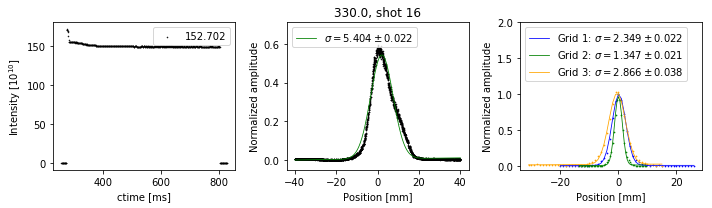

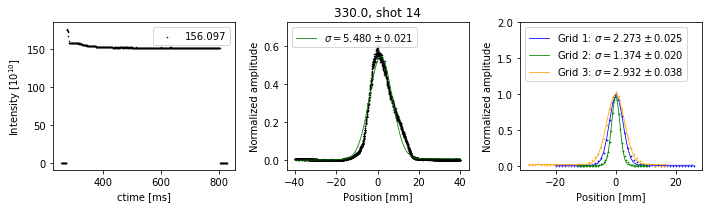

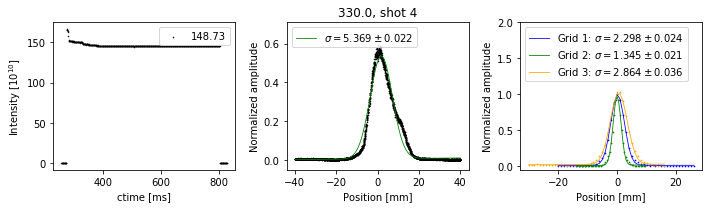

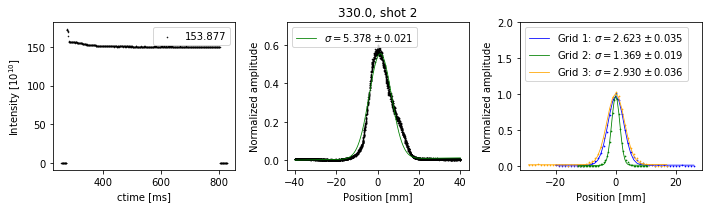

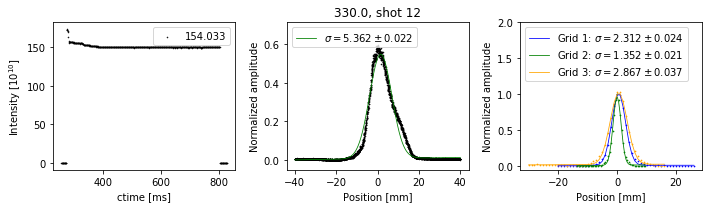

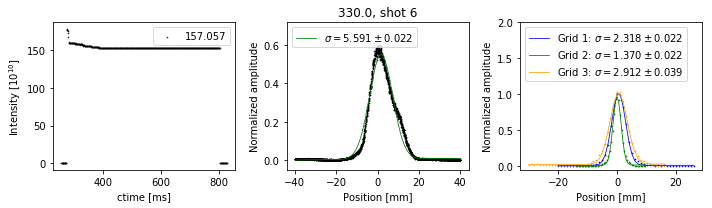

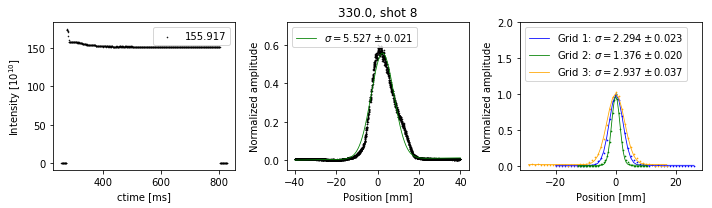

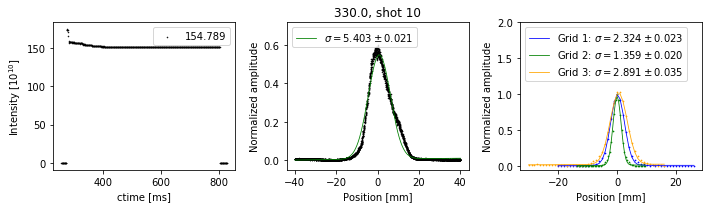

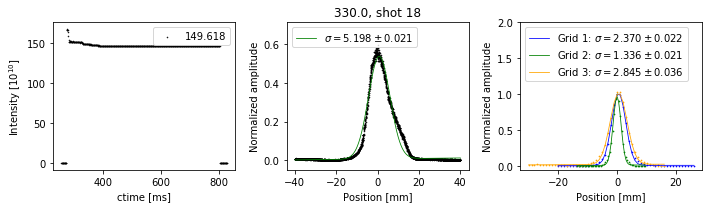

Recorded intensities: [ 152.702  156.097  148.73   153.877  154.033  157.057  155.917  154.789
  149.618]
Intensities after outlier exclusion: [152.702, 156.09700000000001, 0, 153.87700000000001, 154.03300000000002, 0, 155.917, 154.78900000000002, 0]
Beta wire: 4.210392712
Beta rel: 0.39244 Gamma rel: 1.08722
2.95263008903 152.702
3.03629043879 156.097
2.91494320242 0
An intensity value was excluded.
2.92478120516 153.877
2.90689937754 154.033
3.16039355101 0
An intensity value was excluded.
3.08865308216 155.917
2.95165487253 154.789
2.73197681049 0
An intensity value was excluded.

Normal emittance: [ 2.95263009  3.03629044  2.9149432   2.92478121  2.90689938  3.16039355
  3.08865308  2.95165487  2.73197681] 2.96313584768 0.115782173997
Normalized emittance: [1.9924889538060282, 2.004381390552286, 1.9586249344763123, 1.9446785834634808, 2.0413020304900225, 1.9649752628152823] 1.98440852593 0.03246021444
Intensity: [ 152.702  156.097  148.73   153.877  154.033  157.057  155.917  154.7

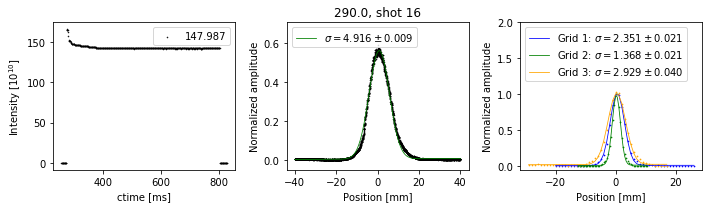

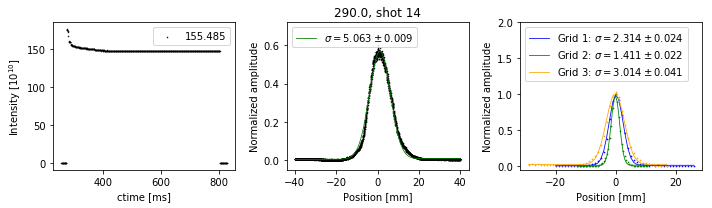

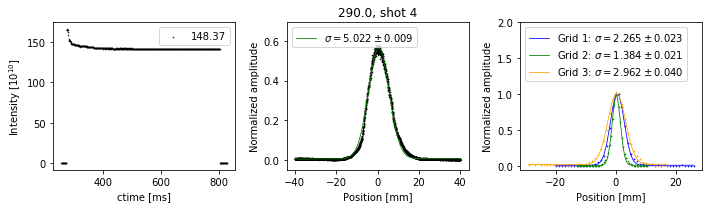

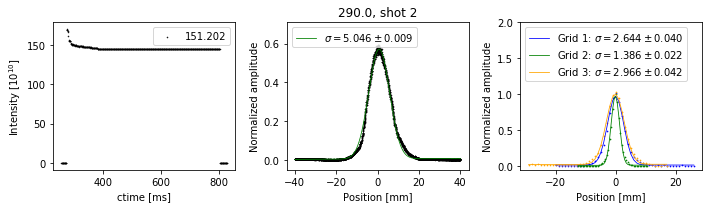

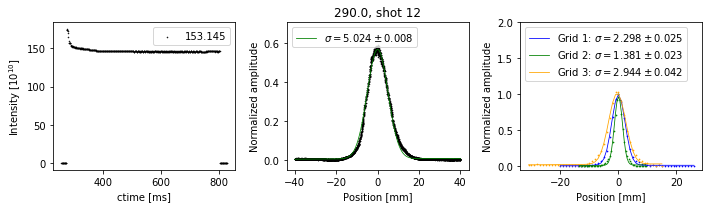

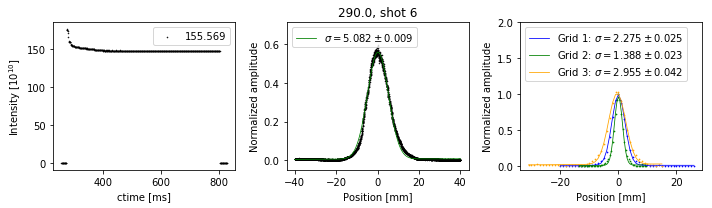

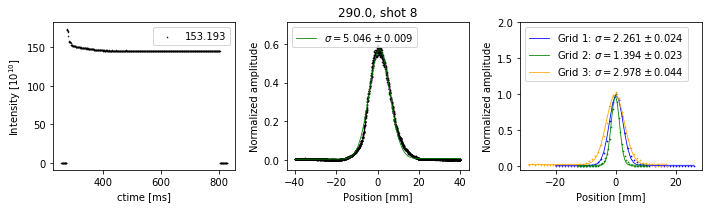

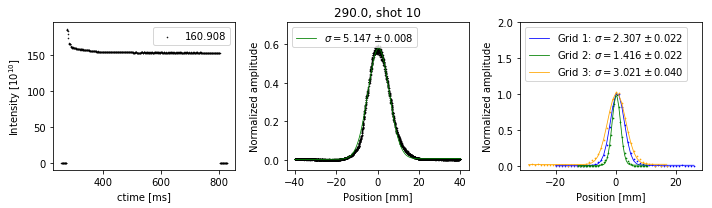

Recorded intensities: [ 147.987  155.485  148.37   151.202  153.145  155.569  153.193  160.908]
Intensities after outlier exclusion: [0, 155.48500000000001, 0, 151.202, 153.14500000000001, 155.56900000000002, 153.19300000000001, 0]
Beta wire: 4.210708026875
Beta rel: 0.3304 Gamma rel: 1.0595
2.00442704398 0
An intensity value was excluded.
2.12643739679 155.485
2.09186204857 0
An intensity value was excluded.
2.1123192916 151.202
2.09404607823 153.145
2.14270818392 155.569
2.11232755672 153.193
2.19758134233 0
An intensity value was excluded.

Normal emittance: [ 2.00442704  2.1264374   2.09186205  2.11231929  2.09404608  2.14270818
  2.11232756  2.19758134] 2.11021361777 0.0509289926652
Normalized emittance: [1.3139266042920927, 1.3421746517964646, 1.3136824997995322, 1.3232654432391653, 1.3247360242740134] 1.32355704468 0.0103763417223
Intensity: [ 147.987  155.485  148.37   151.202  153.145  155.569  153.193  160.908]

Outliers excluded: [1.3139266042920927, 1.3421746517964646, 1.31

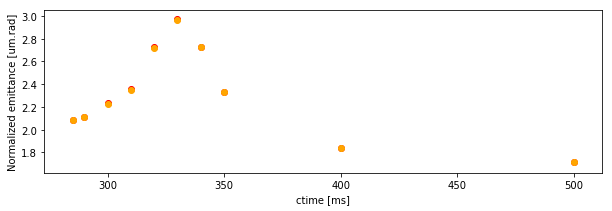

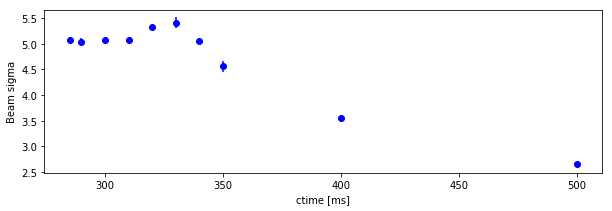

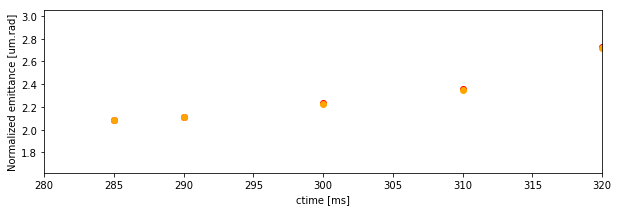

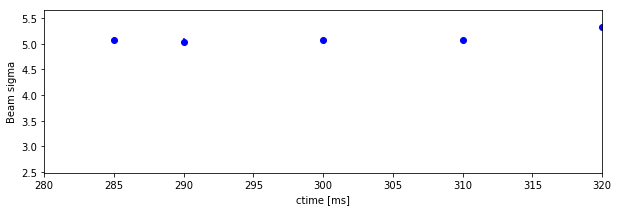

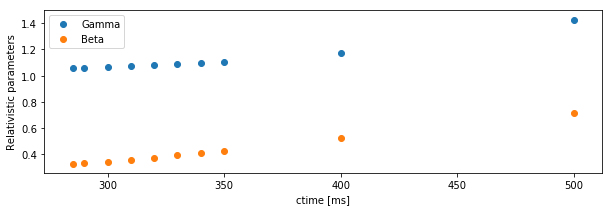

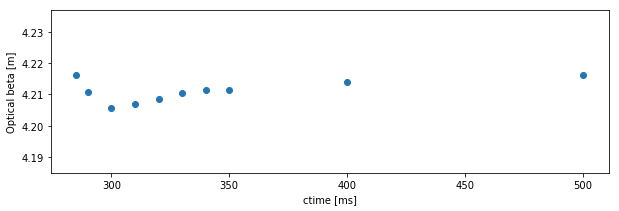

In [51]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('PROFILE_(.*)_V', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

# plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue")
plt.scatter(ctime, (np.asarray(sigma)**2/np.asarray(beta_wire))*np.asarray(gamma_rel)*np.asarray(beta_rel), color="red")
plt.scatter(ctime, (np.asarray(sigma)**2/4.22)*np.asarray(gamma_rel)*np.asarray(beta_rel), color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
# plt.xlim([280, 600])
# plt.title("Normalized to intensity")
plt.show()
plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)
plt.clf()

plt.errorbar(ctime, sigma, yerr=sigma_err, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Beam sigma")
# plt.xlim([280, 600])
plt.show()
plt.clf()


plt.scatter(ctime, (np.asarray(sigma)**2/np.asarray(beta_wire))*np.asarray(gamma_rel)*np.asarray(beta_rel), color="red")
plt.scatter(ctime, (np.asarray(sigma)**2/4.22)*np.asarray(gamma_rel)*np.asarray(beta_rel), color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
plt.xlim([280, 320])
# plt.title("Normalized to intensity")
plt.show()
plt.clf()

plt.errorbar(ctime, sigma, yerr=sigma_err, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Beam sigma")
plt.xlim([280, 320])
plt.show()
plt.clf()

plt.scatter(ctime, gamma_rel, label="Gamma")
plt.scatter(ctime, beta_rel, label="Beta")
plt.xlabel("ctime [ms]")
plt.ylabel("Relativistic parameters")
plt.legend()
plt.show()
plt.clf()

plt.scatter(ctime, beta_wire)
plt.xlabel("ctime [ms]")
plt.ylabel("Optical beta [m]")
plt.show()
plt.clf()

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.